In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
#alt method
inspect(engine).get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
# Use inspector to see column names
columns = inspect(engine).get_columns('measurement')
for col in columns:
    print(col["name"], col["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Query for the most_recent date in dataset
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(str(most_recent))
type(most_recent)

2017-08-23


str

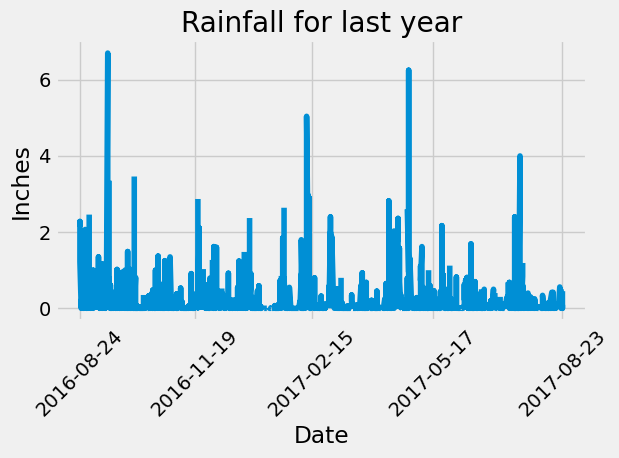

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_back = dt.datetime.strptime(most_recent, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
# Query for all data within one year of the most recent observation
data = session.query(Measurement).filter(Measurement.date >= one_year_back)

# # Look at the queried data
# for d in data:
#     print(f"On {d.date}, the precipitation was {d.prcp}")

# Print the size of dataset
len(data.all())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.read_sql(data.statement, session.bind)

# Sort the dataframe by date
df = df.sort_values(by='date', ascending=True)


# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df['date'], df['prcp'])
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Rainfall for last year')
plt.grid(True)

## OpenAI assisted with figuring out the x ticks
# Set the x-axis ticks for only 5 dates
x_ticks = df['date'].iloc[::len(df['date']) // 4]  # Select every 1/4th date
plt.xticks(x_ticks, rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
pd.DataFrame(df['prcp'].describe())

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Use inspector to look at column names
columns = inspect(engine).get_columns('station')
for col in columns:
    print(col["name"], col["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station).distinct().count()

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activity = pd.read_sql("SELECT station, COUNT(date) FROM measurement GROUP BY station ORDER BY COUNT(date) DESC", engine.connect())
activity

,station,COUNT(date)
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
pd.read_sql(f"SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement WHERE station = '{activity.station[0]}'", engine.connect())


,MIN(tobs),MAX(tobs),AVG(tobs)
0,54.0,85.0,71.663781


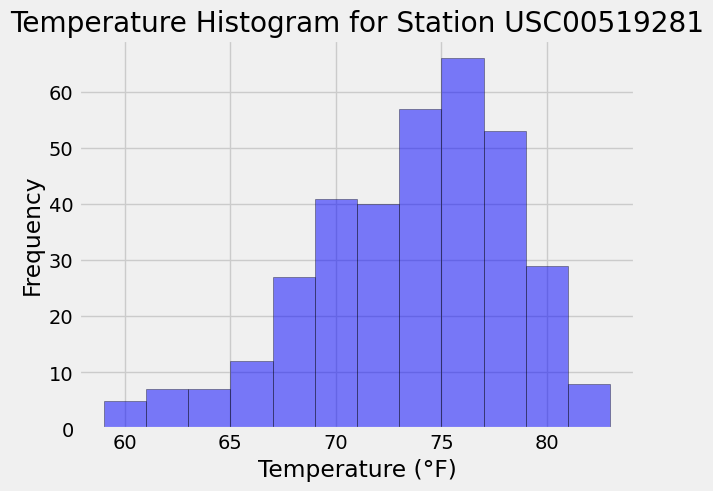

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
date_string = one_year_back.strftime("%Y-%m-%d")
data = pd.read_sql(f"SELECT tobs FROM measurement WHERE date >= '{date_string}' AND station = '{activity.station[0]}'", engine.connect())

plt.hist(data['tobs'], bins=12, alpha=0.5, color='blue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Histogram for Station USC00519281')
plt.grid(True)

# Display the histogram
plt.show()

# Close Session

In [19]:
# Close Session
session.close()